## Start the NLP server


In [37]:
import os

STANFORD_NLP_LOCATION = '~/stanford-corenlp-full-2018-10-05/' # the location of the Stanford NLP library on my computer 
                                                              #(download at https://stanfordnlp.github.io/CoreNLP)
STANFORD_NLP_TIMEOUT = 10000 # the time after which a given NLP request will be killed if not yet complete

exec = os.popen
exec('cd %s; java -mx5g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -timeout %s' % 
     (STANFORD_NLP_LOCATION, STANFORD_NLP_TIMEOUT))

## Create function to determine the sentiment of a block of text

In [2]:
from pycorenlp import StanfordCoreNLP
import numpy

MIN_SENTIMENT = 0
MAX_SENTIMENT = 4

# Determines the sentiment of a given block of text as a range from 0 (Extremely Negative) to 4 (Extremely Positive).
def findSentiment(text):
    NLP_SERVER_LOCATION = 'http://localhost:9000'
    PROPERTIES_DICTIONARY = {'annotators': 'sentiment', 'outputFormat': 'json', 'timeout': 1000}
    
    nlp = StanfordCoreNLP(NLP_SERVER_LOCATION)
    result = nlp.annotate(text, properties = PROPERTIES_DICTIONARY)

    sentiments = []
    for sentenceAnalysis in result['sentences']:
        sentimentValue = float(sentenceAnalysis['sentimentValue'])
        sentiments += [sentimentValue]
    return numpy.average(sentiments)

#print(findSentiment(TEXT))

## Create gauge visual for sentiment reading

In [56]:
%matplotlib notebook
import os, sys
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle

ARROW_TAIL_RADIUS = 0.015

# Determines the range of angles which represent each portion of a gauge with n items.
def degreeRange(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = (start + end)/2.0
    return np.c_[start, end], mid_points

# Rotates a piece of text by a given angle.
def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

# Linearly maps a value within one range to a new range.
def map(num, init_min, init_max, new_min, new_max):
    return (num - init_min) * (new_max - new_min) / (init_max - init_min) + new_min

'''
Creates and displays a gauge. Returns a tuple with the arrow and axes used for convenient modification.
'''
def gauge(labels, colors, currentVal, minVal, maxVal, title='', fname=False): 
    N = len(labels)

    if isinstance(colors, list): 
        colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degreeRange(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels):
        AVG_STR_LENGTH = 12
        AVG_FONT_SIZE = 11
        MAX_FONT_SIZE = 30
        
        fontSize = min(AVG_STR_LENGTH / len(lab) * AVG_FONT_SIZE, MAX_FONT_SIZE) # create dynamic font size based on string length
        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab,
            horizontalalignment='center', verticalalignment='center', fontsize=fontSize,
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center',
         verticalalignment='center', fontsize=22, fontweight='bold')

    #Plot the arrow based on given sentiment value.
    lowestAngle = ang_range[0][0]
    highestAngle = ang_range[-1][1]
    
    pos = map(currentVal, minVal, maxVal, highestAngle, lowestAngle)
    
    arrow = ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
                 width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
    #arrow.remove()
    
    ax.add_patch(Circle((0, 0), radius=ARROW_TAIL_RADIUS, facecolor='k')) # make the arrow rounded at the tail

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)
    
    return (arrow, ax, fig)

## Create function to compute and display sentiment value

In [57]:
def displaySentimentNum(sentimentVal):
    return gauge(labels=['Very Negative','Negative','Neutral','Positive', 'Very Positive'], 
      colors=['#c80000','#c84b00','#646400','#64a000', '#00c800'], currentVal=sentimentVal, minVal = MIN_SENTIMENT, maxVal = MAX_SENTIMENT, title='Cryptocurrency Sentiment')
def displaySentimentTxt(text):
    return displaySentimentNum(findSentiment(text))    

## Scrape web for news article

2.0


<IPython.core.display.Javascript object>


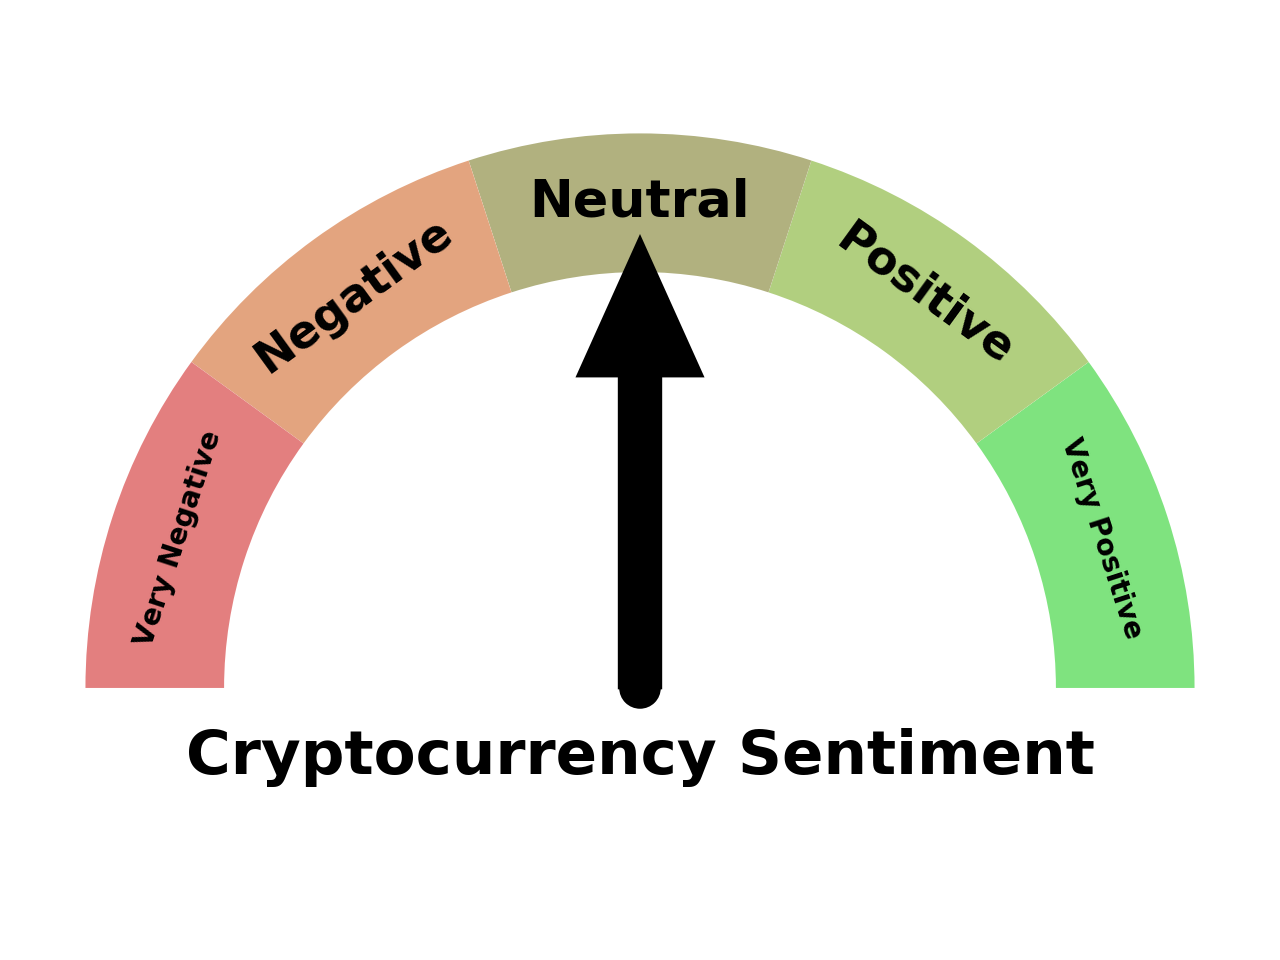

In [44]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from newsapi import NewsApiClient

def getPageContent(url):
    try: 
        with closing(get(url, stream = True)) as page:
            return page.content.decode("utf-8")
    except RequestException as e:
        print(e)
        return
    
def parseHTML(url):
    return BeautifulSoup(getPageContent(url), 'html.parser')

# Extracts the text from a CNN article with given URL, excluding the headline and any advertisements.
def getCNNText(url):
    htmlParser = parseHTML(url)
    
    text = ""

    for element in htmlParser.select('div'):
        if element.has_attr('class') and 'zn-body__paragraph' in element['class']: 
            text += element.text 
    return text
text = "Random text."#getCNNText("https://www.cnn.com/2019/06/26/business/bitcoin-value-trnd/index.html")
displaySentiment(text)

# Uses NewsAPI to extract all articles from a given day.
def getArticleURLs(day, month, year):
    dayPrefix = "%04d-%02d-%02d" % (year, month, day)
    
    newsapi = NewsApiClient(api_key = '8d99d69a251a453f8c084f4768db7195')
    
    urls = []
    second = 0
    minute = 0
    for hour in range (0, 24):
        for minute in range (0, 59, 10):
            iso8601DateStart = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute, second))
            iso8601DateEnd = "%sT%s" % (dayPrefix, "%02d:%02d:%02d" % (hour, minute + (10 if minute != 50 else 9), second))
            all_articles = newsapi.get_everything(q='bitcoin', from_param= iso8601DateStart, to=iso8601DateEnd, page=1)
            for article in all_articles['articles']:
                urls += article['url']
    return urls

## Create widgets for dynamic weights

<IPython.core.display.Javascript object>


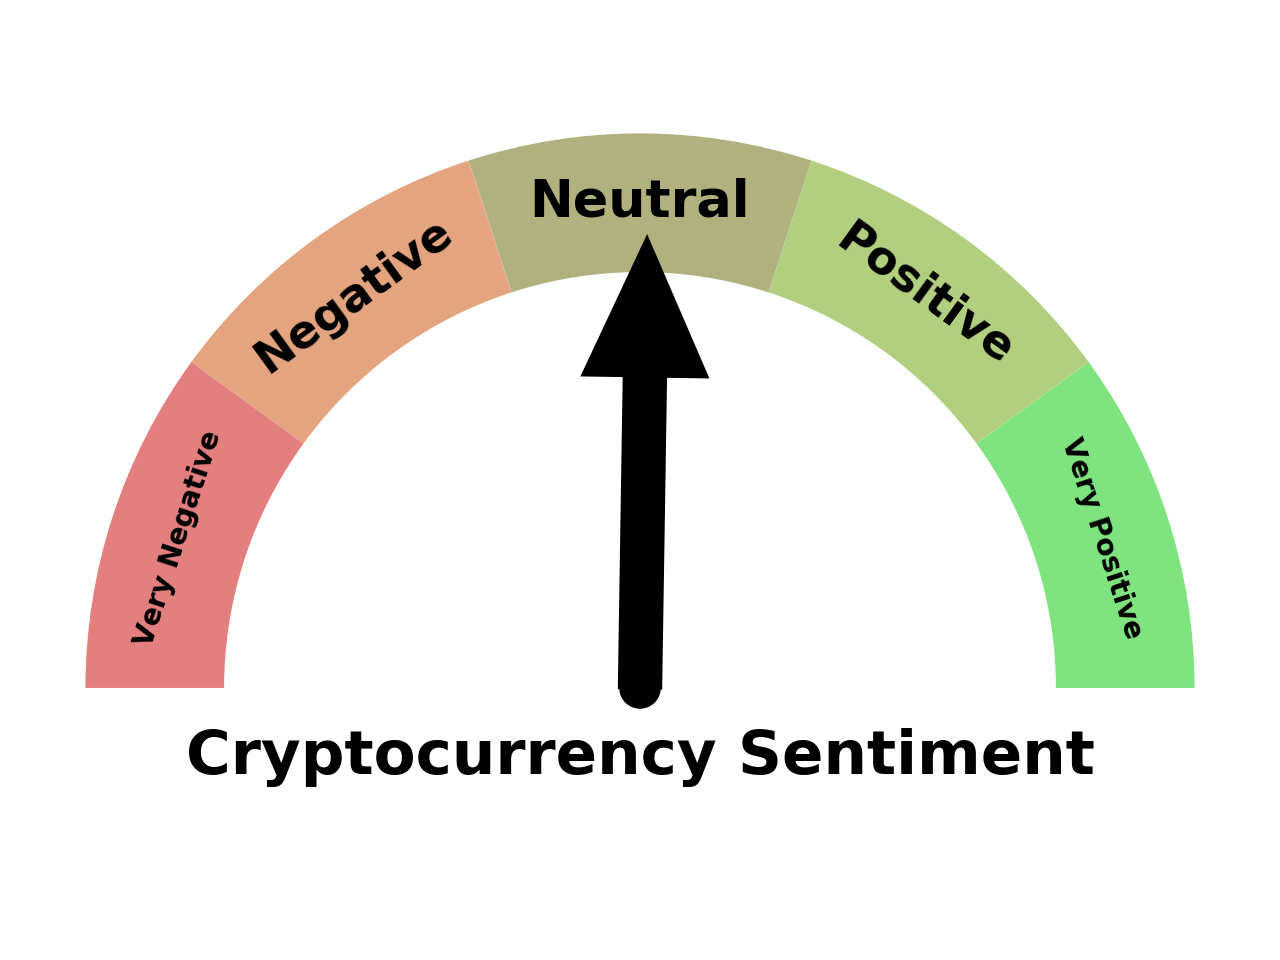

FloatSlider(value=2.0, description='Sentiment Slider', max=4.0, step=0.01)

In [58]:
import ipywidgets as widgets
from IPython.display import display

gaugeArrow, gaugeAxes, fig = displaySentimentNum(2)

def updateSentiment(change):
    global gaugeArrow
    gaugeArrow.remove()
    highestAngle = 180
    lowestAngle = 0
    pos = map(change['new'], MIN_SENTIMENT, MAX_SENTIMENT, highestAngle, lowestAngle)
    gaugeArrow = gaugeAxes.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)),
        width=0.03, head_width=0.09, head_length=0.1, fc='k', ec='k')
    fig.canvas.draw_idle()
    
slider = widgets.FloatSlider(min=0.0, max=4.0, step=0.01, value=2.0, description="Sentiment Slider")
slider.observe(updateSentiment, names='value')
display(slider)

## Create function to retrieve Fear and Greed Index from any given date

<IPython.core.display.Javascript object>


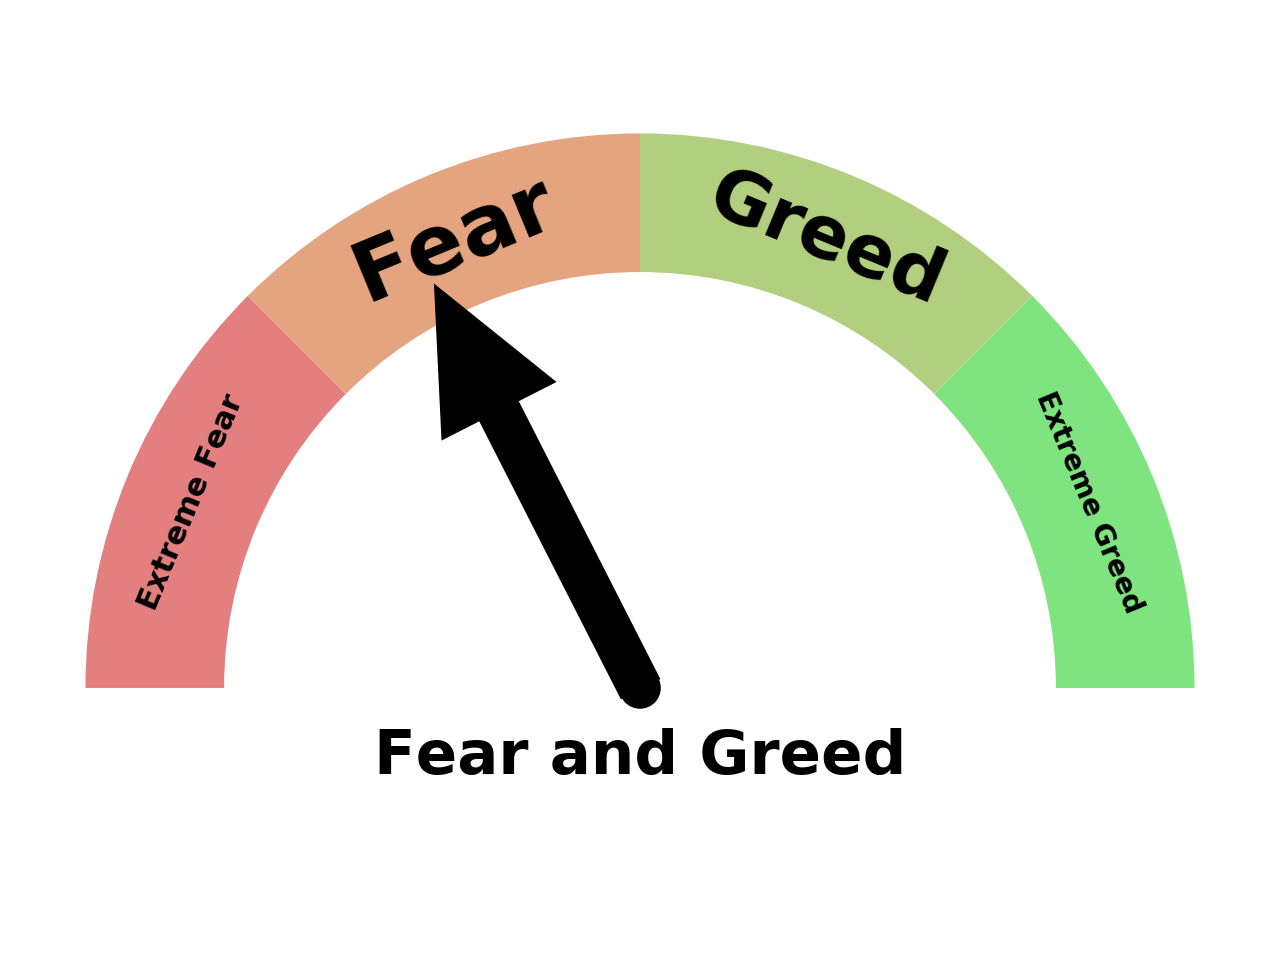

(<matplotlib.patches.FancyArrow at 0x11f8e1ac8>,
 <Figure size 640x480 with 1 Axes>)

In [72]:
import json
FEAR_AND_GREED_ADDRESS = "https://api.alternative.me/fng/?limit=0&date_format=us"
    
MIN_FEAR_AND_GREED = 0
MAX_FEAR_AND_GREED = 100

def getFearAndGreed(month, day, year):
    timestampFormatted = "%02d-%02d-%04d" % (month, day, year)
    
    fearAndGreedVals = getPageContent(FEAR_AND_GREED_ADDRESS)
    jsonUnpacked = json.loads(fearAndGreedVals)
    dataArr = jsonUnpacked['data']
    
    for singleDay in dataArr:
        if singleDay['timestamp'] == timestampFormatted:
            return int(singleDay['value'])

def displayFearAndGreedNum(val):
    return gauge(labels=['Extreme Fear','Fear','Greed','Extreme Greed'], 
      colors=['#c80000','#c84b00','#64a000', '#00c800'], currentVal=val, minVal = MIN_FEAR_AND_GREED,
                 maxVal = MAX_FEAR_AND_GREED, title='Fear and Greed')
def displayFearAndGreedDate(month, day, year):
    return displayFearAndGreedNum(getFearA)
displayFearAndGreedNum(35)

## Kill the NLP server

In [8]:
exec('kill $(lsof -ti tcp:9000)')